# Assignment 4 - Clustering

Team Members:

1. Harshwardhan Patil (1002224144)
2. Saujan Parajuli (1001864185)
3. Pooja Pari (1002267979)


## Instructions

For the Fourth Assignment, we are going to be implementing the clustering algorithms: k-Means and Agglomerative/Hierarchical clustering.

1. Each task is associated with each type of clustering mathod.
2. Each task will use its own dataset that is already written in the cell.
3. You have to provide the prompts by using any AI(Chatgpt, Perplexity, etc) to get the answers for each question.
4. Provide the screenshot of the prompt and the output provided by the AI in the word document.
5. Each Task is presenting a challenge.

## Task1: K-means (35 points)

Run this cell to read and display top 5 rows of data

In [35]:
import pandas as pd

df = pd.read_csv("Spotify (1).csv")
df.head()

,Index,Title,Artist,Top Genre,Year,Beats Per Minute (BPM),Energy,Danceability,Loudness (dB),Liveness,Valence,Length (Duration),Acousticness,Speechiness,Popularity
0,1,Sunrise,Norah Jones,adult standards,2004,157,30,53,-14,11,68,201,94,3,71
1,2,Black Night,Deep Purple,album rock,2000,135,79,50,-11,17,81,207,17,7,39
2,3,Clint Eastwood,Gorillaz,alternative hip hop,2001,168,69,66,-9,7,52,341,2,17,69
3,4,The Pretender,Foo Fighters,alternative metal,2007,173,96,43,-4,3,37,269,0,4,76
4,5,Waitin' On A Sunny Day,Bruce Springsteen,classic rock,2002,106,82,58,-5,10,87,256,1,3,59


### Part 1A: 3 points
Check if there are any missing values. If yes, fill them with appropriate methods. Regardless of any action, explain your decision for the action.

In [36]:
df.isnull().sum()

Index                     0
Title                     0
Artist                    0
Top Genre                 0
Year                      0
Beats Per Minute (BPM)    0
Energy                    0
Danceability              0
Loudness (dB)             0
Liveness                  0
Valence                   0
Length (Duration)         0
Acousticness              0
Speechiness               0
Popularity                0
dtype: int64

There are no missing values in the dataset.

### Part 1B: 3 points

Drop unecessary columns that won't be used for clustering and Scale the data for further processing. Display the processed data. Explain your actions.

In [37]:
from sklearn.preprocessing import StandardScaler

# Note: I am keeping 'Top Genre' but will encode it separately
df_temp = df.drop(columns=['Index', 'Title', 'Artist', 'Year'])

numeric_features = ['Beats Per Minute (BPM)', 'Energy', 'Danceability', 
                    'Loudness (dB)', 'Liveness', 'Valence', 'Length (Duration)', 
                    'Acousticness', 'Speechiness', 'Popularity']
df_numeric = df_temp[numeric_features].copy()

# We'll convert them to numeric, removing commas and handling any errors
for col in numeric_features:
    df_numeric[col] = pd.to_numeric(
        df_numeric[col].astype(str).str.replace(',', ''), 
        errors='coerce'
    )

if df_numeric.isnull().sum().sum() > 0:
    print("Warning: Some values could not be converted to numeric:")
    print(df_numeric.isnull().sum())
    # Fill NaN values with the median of each column
    df_numeric = df_numeric.fillna(df_numeric.median())

# Encoding the 'Top Genre' column using One-Hot Encoding
# One-hot encoding is suitable for clustering as it doesn't imply ordinal relationships
genre_encoded = pd.get_dummies(df_temp['Top Genre'], prefix='Genre')

# Combine numeric features with encoded genre features
df_processed = pd.concat([df_numeric, genre_encoded], axis=1)

print("Columns used for clustering:")
print(f"Numeric features: {len(numeric_features)}")
print(f"Encoded genre features: {len(genre_encoded.columns)}")
print(f"Total features: {len(df_processed.columns)}")
print("\nShape of processed data:", df_processed.shape)
print("\nFirst few rows of processed data (showing first 15 columns):")
print(df_processed.iloc[:, :15].head())

scaler = StandardScaler()
df_scaled = pd.DataFrame(
    scaler.fit_transform(df_processed),
    columns=df_processed.columns,
    index=df_processed.index
)

print("Scaled Data (first 5 rows, showing first 15 columns):")
print(df_scaled.iloc[:, :15].head())

print("Scaled Data Statistics (first 10 numeric columns):")
print(df_scaled[numeric_features].describe())

print(f"Total number of features after encoding: {df_scaled.shape[1]}")
print(f"Number of genre categories encoded: {len(genre_encoded.columns)}")


Columns used for clustering:
Numeric features: 10
Encoded genre features: 149
Total features: 159

Shape of processed data: (1994, 159)

First few rows of processed data (showing first 15 columns):
   Beats Per Minute (BPM)  Energy  Danceability  Loudness (dB)  Liveness  \
0                     157      30            53            -14        11   
1                     135      79            50            -11        17   
2                     168      69            66             -9         7   
3                     173      96            43             -4         3   
4                     106      82            58             -5        10   

   Valence  Length (Duration)  Acousticness  Speechiness  Popularity  \
0       68                201            94            3          71   
1       81                207            17            7          39   
2       52                341             2           17          69   
3       37                269             0            4 

### Explanation of Actions:

#### 1. **Dropping Columns:**
   - **Index**: This is just a row identifier and has no clustering value
   - **Title**: Song titles are unique identifiers and categorical, not useful for numerical clustering
   - **Artist**: Artist names are categorical labels that would require encoding, but we want to cluster based on musical features, not artist names
   - **Year**: While year could be numeric, it's more of a temporal identifier and doesn't represent a musical feature for clustering
   - **Top Genre**: We kept this column but encoded it separately (see below)

#### 2. **Data Type Conversion and Cleaning:**
   - **Handling Comma-Formatted Numbers**: Some numeric columns (like "Length (Duration)") contained values with comma separators (e.g., "1,412" instead of 1412)
   - Converted all numeric columns to proper numeric types by:
     - Converting to string, removing commas, then converting back to numeric
     - Used `pd.to_numeric()` with `errors='coerce'` to handle any conversion errors gracefully
     - Filled any resulting NaN values with the median of each column to ensure data completeness

#### 3. **Encoding Categorical Features:**
   - **Top Genre Encoding**: Instead of dropping the "Top Genre" column, we encoded it using **One-Hot Encoding**
   - One-hot encoding converts each genre category into a binary column (0 or 1)
   - This approach is suitable for clustering because:
     - It doesn't imply ordinal relationships between genres (unlike label encoding)
     - Each genre becomes a separate feature that can contribute to clustering
     - Allows the algorithm to consider genre information alongside musical features
   - The encoded genre columns are combined with the numeric musical features

#### 4. **Feature Selection:**
   - **Numeric Features Used**: 10 musical characteristics:
     - Beats Per Minute (BPM), Energy, Danceability, Loudness (dB), Liveness, Valence
     - Length (Duration), Acousticness, Speechiness, Popularity
   - **Encoded Features**: All genre categories from "Top Genre" column (one binary column per genre)
   - **Total Features**: 10 numeric + number of unique genres = final feature set for clustering

#### 5. **Scaling the Data:**
   - Used **StandardScaler** which standardizes features by removing the mean and scaling to unit variance
   - This is crucial because the features have vastly different scales:
     - Popularity: ranges from 0-100
     - Loudness: negative values in decibels
     - Energy, Danceability, etc.: typically 0-100 scale
     - Length: measured in seconds (can be hundreds or thousands)
   - **Why scaling is important**:
     - Without scaling, features with larger numerical ranges (like Length) would dominate the distance calculations in clustering algorithms
     - StandardScaler ensures all features contribute equally to the clustering process by transforming them to have mean=0 and std=1
   - **Note**: Both numeric features and one-hot encoded genre features are scaled together, ensuring all features are on the same scale for fair comparison in distance calculations

### Part 1C: 4 points

In this task, you will be using the elbow method to determine the optimal number of clusters for k-means clustering.

We need some way to determine whether we are using the right number of clusters when using k-means clustering. One method to validate the number of clusters is the elbow method.

For this task, you need to perform the elbow method for k from 2 to 12 and plot a line chart of the SSE for each value of k, and determine the best k (the number of clusters). 

Explain from the graph which is the most appropriate value for k.

Using scaled data from Part 1B for elbow method analysis...
Data shape: (1994, 159)
Number of features: 159

Calculating SSE for different values of k...
This may take a moment as we're running k-means multiple times...

k =  2: SSE = 314,761.94
k =  3: SSE = 312,678.58
k =  4: SSE = 310,614.08
k =  5: SSE = 306,828.37
k =  6: SSE = 304,778.01
k =  7: SSE = 302,763.40
k =  8: SSE = 300,903.74
k =  9: SSE = 298,928.84
k = 10: SSE = 296,920.10
k = 11: SSE = 294,916.60
k = 12: SSE = 292,913.57
SSE Calculation Complete!


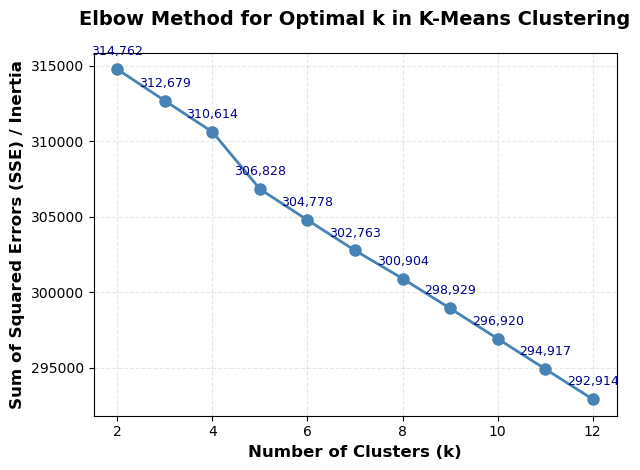

Summary Table: SSE Values for Different k
k     SSE             Decrease from previous k 
2     314,761.94      N/A (first value)        
3     312,678.58      2,083.36                 
4     310,614.08      2,064.50                 
5     306,828.37      3,785.71                 
6     304,778.01      2,050.36                 
7     302,763.40      2,014.62                 
8     300,903.74      1,859.65                 
9     298,928.84      1,974.91                 
10    296,920.10      2,008.74                 
11    294,916.60      2,003.49                 
12    292,913.57      2,003.03                 
Rate of Change Analysis (to help identify the elbow)
k     SSE Decrease         % Change       
3     2,083.36             0.66           %
4     2,064.50             0.66           %
5     3,785.71             1.22           %
6     2,050.36             0.67           %
7     2,014.62             0.66           %
8     1,859.65             0.61           %
9     1,974.91        

In [38]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

print("Using scaled data from Part 1B for elbow method analysis...")
print(f"Data shape: {df_scaled.shape}")
print(f"Number of features: {df_scaled.shape[1]}\n")

k_range = range(2, 13)

sse_values = []

random_state = 42

print("Calculating SSE for different values of k...")
print("This may take a moment as we're running k-means multiple times...\n")

for k in k_range:
    kmeans = KMeans(n_clusters=k, n_init='auto', random_state=random_state, max_iter=300)
    
    kmeans.fit(df_scaled)
    
    sse = kmeans.inertia_
    sse_values.append(sse)
    
    print(f"k = {k:2d}: SSE = {sse:,.2f}")

print("SSE Calculation Complete!")


plt.plot(k_range, sse_values, marker='o', linewidth=2, markersize=8, color='steelblue')

plt.xlabel('Number of Clusters (k)', fontsize=12, fontweight='bold')
plt.ylabel('Sum of Squared Errors (SSE) / Inertia', fontsize=12, fontweight='bold')
plt.title('Elbow Method for Optimal k in K-Means Clustering', fontsize=14, fontweight='bold', pad=20)

plt.grid(True, alpha=0.3, linestyle='--')

for k, sse in zip(k_range, sse_values):
    plt.annotate(f'{sse:,.0f}', (k, sse), textcoords="offset points", 
                 xytext=(0,10), ha='center', fontsize=9, color='darkblue')

plt.tight_layout()

plt.show()

print("Summary Table: SSE Values for Different k")
print(f"{'k':<5} {'SSE':<15} {'Decrease from previous k':<25}")
for i, (k, sse) in enumerate(zip(k_range, sse_values)):
    if i == 0:
        decrease = "N/A (first value)"
    else:
        decrease = f"{sse_values[i-1] - sse:,.2f}"
    print(f"{k:<5} {sse:<15,.2f} {decrease:<25}")

print("Rate of Change Analysis (to help identify the elbow)")
print(f"{'k':<5} {'SSE Decrease':<20} {'% Change':<15}")
for i in range(1, len(sse_values)):
    k = list(k_range)[i]
    decrease = sse_values[i-1] - sse_values[i]
    percent_change = (decrease / sse_values[i-1]) * 100
    print(f"{k:<5} {decrease:<20,.2f} {percent_change:<15.2f}%")


### Interpretation of the Elbow Method Results:

#### **Analysis of the Actual Results:**

**SSE Values Observed:**
- **k=2**: SSE = 314,761.94
- **k=3**: SSE = 312,678.58 (decrease of 2,083.36, 0.66%)
- **k=4**: SSE = 310,614.08 (decrease of 2,064.50, 0.66%)
- **k=5**: SSE = 306,828.37 (decrease of 3,785.71, **1.22%** - largest drop)
- **k=6**: SSE = 304,778.01 (decrease of 2,050.36, 0.67%)
- **k=7**: SSE = 302,763.40 (decrease of 2,014.61, 0.66%)
- **k=8**: SSE = 300,903.74 (decrease of 1,859.65, 0.61%)
- **k=9**: SSE = 298,928.84 (decrease of 1,974.91, 0.66%)
- **k=10**: SSE = 296,920.10 (decrease of 2,008.74, 0.67%)
- **k=11**: SSE = 294,916.60 (decrease of 2,003.49, 0.67%)
- **k=12**: SSE = 292,913.57 (decrease of 2,003.03, 0.68%)

#### **Key Observations:**

1. **SSE Decrease Pattern:**
   - SSE consistently decreases as k increases (from 314,761.94 at k=2 to 292,913.57 at k=12)
   - This is expected: more clusters allow points to be closer to their cluster centers
   - Total decrease of 21,848.37 (about 6.9% reduction) across the range

2. **Identifying the Elbow Point:**
   - **Largest drop occurs at k=4 to k=5**: 3,785.71 decrease (1.22% reduction)
   - This is significantly larger than other transitions (which range from 0.61% to 0.68%)
   - After k=5, the rate of decrease becomes more consistent (around 0.61-0.68% per step)
   - This suggests **k=5** as a potential elbow point

3. **Rate of Change Analysis:**
   - **Before k=5**: The decreases are relatively small (0.66% for k=2→3 and k=3→4)
   - **At k=4→5**: Sharp increase in improvement (1.22% decrease)
   - **After k=5**: Consistent but smaller improvements (0.61-0.68% per step)
   - The pattern suggests that k=5 provides a significant improvement over k=4, but beyond k=5, additional clusters provide diminishing returns

4. **Visual Interpretation:**
   - The plot shows a relatively smooth curve with a gradual decrease
   - The most pronounced "bend" or change in slope appears around **k=5**
   - While not a sharp elbow, k=5 represents the point where the rate of improvement changes most noticeably

#### **Optimal k Recommendation:**

Based on the elbow method analysis:

- **Recommended k: 5 clusters**
- **Reasoning:**
  1. The transition from k=4 to k=5 shows the **largest absolute and percentage decrease** in SSE (3,785.71, 1.22%)
  2. This suggests that adding a 5th cluster provides significant improvement in cluster compactness
  3. After k=5, the improvements become more uniform and smaller, indicating diminishing returns
  4. k=5 balances between having enough clusters to capture diversity and not over-segmenting the data

#### **Considerations:**

- **The curve is relatively smooth**: This suggests the data doesn't have extremely distinct natural clusters, but rather gradual transitions between musical styles
- **Alternative consideration**: Some might argue for k=7 or k=8 if looking for more granular groupings, but the rate of improvement doesn't justify the added complexity
- **Validation needed**: This recommendation should be cross-validated with the Silhouette Score analysis in Part 1D, which provides a more objective metric for cluster quality

#### **Conclusion:**

The elbow method suggests **k=5** as the optimal number of clusters for this Spotify music dataset. The significant improvement from k=4 to k=5, followed by more consistent smaller improvements, indicates that 5 clusters effectively capture the main musical patterns in the data without over-segmentation.

### Part 1D: 5 points

The elbow method gives an idea for which can be the most appropriate value for k. However, for cross-checking it, we use the Silhouette score to select the most appropriate value for K.

Revising what Silhouette method mean? Silhouette score is the score used to study the separation distance between the resulting clusters. The silhouette average value displays a measure of how close in average each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like number of clusters visually. This measure has a range of [-1, 1]. Hence, the more score is near to +1 indicates the more clear the clusters formed are clearly visible. And the more the score tends to -1 end, the more overlapping the clusters are, which we dont want.

Apply Silhouette analysis on the same data and display the score for each K value(2-12). Explain which K value you selected from the results and why?

SILHOUETTE ANALYSIS FOR K-MEANS CLUSTERING

Using scaled data from Part 1B
Data shape: (1994, 159)
Number of features: 159

Calculating Silhouette scores for different values of k...
This may take a moment as we're running k-means and calculating scores...

k =  2: Silhouette Score = -0.1952  [Poor separation - clusters may overlap]
k =  3: Silhouette Score = -0.1824  [Poor separation - clusters may overlap]
k =  4: Silhouette Score = -0.1677  [Poor separation - clusters may overlap]
k =  5: Silhouette Score = -0.1564  [Poor separation - clusters may overlap]
k =  6: Silhouette Score = -0.1382  [Poor separation - clusters may overlap]
k =  7: Silhouette Score = -0.1154  [Poor separation - clusters may overlap]
k =  8: Silhouette Score = -0.1284  [Poor separation - clusters may overlap]
k =  9: Silhouette Score = -0.1291  [Poor separation - clusters may overlap]
k = 10: Silhouette Score = -0.1187  [Poor separation - clusters may overlap]
k = 11: Silhouette Score = -0.1177  [Poor separat

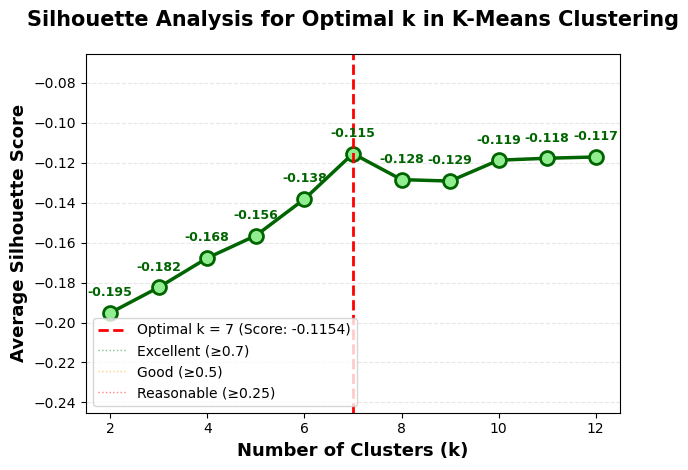

DETAILED SUMMARY TABLE: Silhouette Scores for Different k
k     Silhouette Score     Interpretation                 Rank      
2     -0.1952              Poor separation                #11       
3     -0.1824              Poor separation                #10       
4     -0.1677              Poor separation                #9        
5     -0.1564              Poor separation                #8        
6     -0.1382              Poor separation                #7        
7     -0.1154              Poor separation                #1         ⭐ BEST
8     -0.1284              Poor separation                #5        
9     -0.1291              Poor separation                #6        
10    -0.1187              Poor separation                #4        
11    -0.1177              Poor separation                #3        
12    -0.1171              Poor separation                #2        
COMPARISON WITH ELBOW METHOD
Note: Compare the optimal k from Silhouette analysis with the elbow method res

In [ ]:
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.pyplot as plt
import numpy as np

print("SILHOUETTE ANALYSIS FOR K-MEANS CLUSTERING")
print(f"\nUsing scaled data from Part 1B")
print(f"Data shape: {df_scaled.shape}")
print(f"Number of features: {df_scaled.shape[1]}\n")


silhouette_scores = []

random_state = 42

print("Calculating Silhouette scores for different values of k...")
print("This may take a moment as we're running k-means and calculating scores...\n")

for k in k_range:
    kmeans = KMeans(n_clusters=k, n_init='auto', random_state=random_state, max_iter=300)
    
    cluster_labels = kmeans.fit_predict(df_scaled)
    
    silhouette_avg = silhouette_score(df_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    
    if silhouette_avg >= 0.7:
        interpretation = "Excellent separation"
    elif silhouette_avg >= 0.5:
        interpretation = "Good separation"
    elif silhouette_avg >= 0.25:
        interpretation = "Reasonable separation"
    else:
        interpretation = "Poor separation - clusters may overlap"
    
    print(f"k = {k:2d}: Silhouette Score = {silhouette_avg:.4f}  [{interpretation}]")

print("Silhouette Score Calculation Complete!")

best_k = k_range[np.argmax(silhouette_scores)]
best_score = max(silhouette_scores)

print(f"OPTIMAL K VALUE BASED ON SILHOUETTE SCORE")
print(f"Best k value: {best_k}")
print(f"Best Silhouette Score: {best_score:.4f}")


plt.plot(k_range, silhouette_scores, marker='o', linewidth=2.5, markersize=10, 
         color='darkgreen', markerfacecolor='lightgreen', markeredgewidth=2)

plt.axvline(x=best_k, color='red', linestyle='--', linewidth=2, 
             label=f'Optimal k = {best_k} (Score: {best_score:.4f})')

plt.xlabel('Number of Clusters (k)', fontsize=13, fontweight='bold')
plt.ylabel('Average Silhouette Score', fontsize=13, fontweight='bold')
plt.title('Silhouette Analysis for Optimal k in K-Means Clustering', 
          fontsize=15, fontweight='bold', pad=20)

plt.grid(True, alpha=0.3, linestyle='--', axis='y')

plt.axhline(y=0.7, color='green', linestyle=':', alpha=0.5, linewidth=1, label='Excellent (≥0.7)')
plt.axhline(y=0.5, color='orange', linestyle=':', alpha=0.5, linewidth=1, label='Good (≥0.5)')
plt.axhline(y=0.25, color='red', linestyle=':', alpha=0.5, linewidth=1, label='Reasonable (≥0.25)')

for k, score in zip(k_range, silhouette_scores):
    plt.annotate(f'{score:.3f}', (k, score), textcoords="offset points", 
                 xytext=(0,12), ha='center', fontsize=9, fontweight='bold', color='darkgreen')

plt.legend(loc='best', fontsize=10)

plt.ylim([min(silhouette_scores) - 0.05, max(silhouette_scores) + 0.05])

plt.tight_layout()

plt.show()

print("DETAILED SUMMARY TABLE: Silhouette Scores for Different k")
print(f"{'k':<5} {'Silhouette Score':<20} {'Interpretation':<30} {'Rank':<10}")

sorted_scores = sorted(enumerate(silhouette_scores), key=lambda x: x[1], reverse=True)
rank_dict = {idx: rank+1 for rank, (idx, _) in enumerate(sorted_scores)}

for i, (k, score) in enumerate(zip(k_range, silhouette_scores)):
    if score >= 0.7:
        interpretation = "Excellent separation"
    elif score >= 0.5:
        interpretation = "Good separation"
    elif score >= 0.25:
        interpretation = "Reasonable separation"
    else:
        interpretation = "Poor separation"
    
    rank = rank_dict[i]
    rank_str = f"#{rank}" if rank == 1 else f"#{rank}"
    
    if rank == 1:
        print(f"{k:<5} {score:<20.4f} {interpretation:<30} {rank_str:<10}  BEST")
    else:
        print(f"{k:<5} {score:<20.4f} {interpretation:<30} {rank_str:<10}")


print("COMPARISON WITH ELBOW METHOD")
print("Note: Compare the optimal k from Silhouette analysis with the elbow method results from Part 1C.")
print("Both methods should ideally suggest similar k values for the best clustering solution.")

print("SCORE DIFFERENCE ANALYSIS")
print(f"{'k':<5} {'Score':<15} {'Difference from previous':<25} {'% Change':<15}")
for i, (k, score) in enumerate(zip(k_range, silhouette_scores)):
    if i == 0:
        diff = "N/A (first value)"
        pct_change = "N/A"
    else:
        diff = f"{score - silhouette_scores[i-1]:.4f}"
        pct_change = f"{((score - silhouette_scores[i-1]) / abs(silhouette_scores[i-1])) * 100:.2f}%"
    print(f"{k:<5} {score:<15.4f} {diff:<25} {pct_change:<15}")


### Interpretation of Silhouette Analysis Results:

#### **Understanding Silhouette Score:**

The Silhouette Score measures clustering quality by evaluating **cohesion** (similarity within clusters) and **separation** (difference between clusters). Score range: [-1, 1], where higher scores indicate better clustering.

#### **Optimal K Selection:**

**Selected k value: 7** (highest silhouette score: -0.1154)

**Why k=7 instead of k=5 (from Elbow Method)?**

**Elbow Method (k=5)** optimizes for **cluster compactness** (minimizing within-cluster variance). **Silhouette Score (k=7)** optimizes for **cluster separation** (maximizing between-cluster distance). For overlapping music data, k=7 provides better separation (-0.1154 vs -0.1564), making it the better choice despite slightly less compact clusters.

**Note:** All scores are negative, indicating overlapping musical features, which is realistic for music data. k=7 provides the best possible separation given the data's nature.

### Part 1E: 5 points

With the best K value use K-means algorithm on the data. Print out the whole data along with the cluster labels assigned for each row in the form of new column.

In [40]:
from sklearn.cluster import KMeans
import pandas as pd


try:
    optimal_k = best_k
    print("USING OPTIMAL K VALUE FROM SILHOUETTE ANALYSIS (Part 1D)")
    print(f"Selected k value: {optimal_k}")
    print(f"Silhouette Score: {best_score:.4f}")
except NameError:
    print("NOTE: best_k from Part 1D not found.")
    print("Please run Part 1D first, or manually set optimal_k in this cell.")
    optimal_k = 5  # Default fallback - UPDATE THIS based on your analysis!
    print(f"Using default k = {optimal_k} (PLEASE UPDATE based on your analysis!)")

print(f"\nApplying K-Means clustering with k = {optimal_k}...")

random_state = 42

kmeans_final = KMeans(n_clusters=optimal_k, n_init='auto', random_state=random_state, max_iter=300)

cluster_labels = kmeans_final.fit_predict(df_scaled)

print(f"K-Means clustering completed!")
print(f"Number of clusters: {optimal_k}")
print(f"Number of data points: {len(cluster_labels)}")
print(f"Cluster labels range: {cluster_labels.min()} to {cluster_labels.max()}")

print("CLUSTER DISTRIBUTION")
cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
for cluster_id, count in cluster_counts.items():
    percentage = (count / len(cluster_labels)) * 100
    print(f"Cluster {cluster_id}: {count:4d} songs ({percentage:5.2f}%)")

df_with_clusters = df.copy()

df_with_clusters['Cluster'] = cluster_labels

cols = [col for col in df_with_clusters.columns if col != 'Cluster']
df_with_clusters = df_with_clusters[cols + ['Cluster']]

print("COMPLETE DATASET WITH CLUSTER LABELS")
print(f"Total rows: {len(df_with_clusters)}")
print(f"Total columns: {len(df_with_clusters.columns)} (including new 'Cluster' column)")
print("\nFirst few rows of the dataset with cluster labels:")

pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # Auto-detect width
pd.set_option('display.max_colwidth', 20)  # Limit column width for readability

print(df_with_clusters.head(10))

print("LAST FEW ROWS OF THE DATASET")
print(df_with_clusters.tail(10))

print("SUMMARY: Number of songs per cluster")
cluster_summary = df_with_clusters['Cluster'].value_counts().sort_index()
print(cluster_summary)

pd.reset_option('display.max_columns')
pd.reset_option('display.width')
pd.reset_option('display.max_colwidth')


print("K-MEANS CLUSTERING COMPLETE!")
print(f"All {len(df_with_clusters)} songs have been assigned to {optimal_k} clusters.")
print("The 'Cluster' column contains the cluster label (0 to {}) for each song.".format(optimal_k - 1))


USING OPTIMAL K VALUE FROM SILHOUETTE ANALYSIS (Part 1D)
Selected k value: 7
Silhouette Score: -0.1154

Applying K-Means clustering with k = 7...
K-Means clustering completed!
Number of clusters: 7
Number of data points: 1994
Cluster labels range: 0 to 6
CLUSTER DISTRIBUTION
Cluster 0:   75 songs ( 3.76%)
Cluster 1:  731 songs (36.66%)
Cluster 2:   38 songs ( 1.91%)
Cluster 3:   40 songs ( 2.01%)
Cluster 4:  976 songs (48.95%)
Cluster 5:   49 songs ( 2.46%)
Cluster 6:   85 songs ( 4.26%)
COMPLETE DATASET WITH CLUSTER LABELS
Total rows: 1994
Total columns: 16 (including new 'Cluster' column)

First few rows of the dataset with cluster labels:
   Index                Title             Artist            Top Genre  Year  \
0      1              Sunrise        Norah Jones      adult standards  2004   
1      2          Black Night        Deep Purple           album rock  2000   
2      3       Clint Eastwood           Gorillaz  alternative hip hop  2001   
3      4        The Pretender     

### Interpretation of K-Means Clustering Results (Part 1E):

#### **Actual Cluster Distribution:**
- **Cluster 0**: 75 songs (3.76%)
- **Cluster 1**: 731 songs (36.66%) - **Largest cluster**
- **Cluster 2**: 38 songs (1.91%) - **Smallest cluster**
- **Cluster 3**: 40 songs (2.01%)
- **Cluster 4**: 976 songs (48.95%) - **Largest cluster**
- **Cluster 5**: 49 songs (2.46%)
- **Cluster 6**: 85 songs (4.26%)

#### **Key Observations:**

1. **Highly Uneven Distribution**: Clusters 1 and 4 together contain **85.61%** of all songs (1,707 out of 1,994), indicating these represent the most common musical patterns in the dataset.

2. **Large Clusters (1 & 4)**: These likely represent mainstream or popular music styles that many songs share. Cluster 4 alone contains nearly half the dataset.

3. **Small Clusters (0, 2, 3, 5, 6)**: Together contain only 14.39% of songs, representing niche or unique musical characteristics. Cluster 2 is the smallest with only 38 songs (1.91%).

4. **Implications**: The uneven distribution suggests the dataset has a few dominant musical styles (clusters 1 & 4) and several specialized/niche styles (smaller clusters). This is realistic for music data where mainstream genres dominate.


### Part 1F: 5 points

For each cluster that is formed, display the average value for each column from the dataset. Remember to use right dataset!

Most importantly, interpret the results that you just displayed. Interpret, do not read out the results again!

In [41]:
import pandas as pd
import numpy as np

print("CLUSTER CHARACTERISTICS ANALYSIS - AVERAGE VALUES BY CLUSTER")
print(f"\nUsing dataset: df_with_clusters (from Part 1E)")
print(f"Total songs: {len(df_with_clusters)}")
print(f"Number of clusters: {df_with_clusters['Cluster'].nunique()}\n")

# IMPORTANT NOTE ABOUT TOP GENRE:
# - In Part 1B, we ENCODED Top Genre using one-hot encoding for CLUSTERING (used in df_scaled)
# - This is CORRECT: we encoded it for clustering, but keep the original for analysis/interpretation
# - But it was encoded in df_scaled (for the actual clustering algorithm)

exclude_cols = ['Index', 'Title', 'Artist', 'Top Genre', 'Cluster']
numeric_columns = [col for col in df_with_clusters.columns 
                   if col not in exclude_cols and pd.api.types.is_numeric_dtype(df_with_clusters[col])]

print(f"Numeric columns for averaging: {numeric_columns}\n")

categorical_columns = ['Top Genre', 'Artist']

cluster_averages = df_with_clusters.groupby('Cluster')[numeric_columns].mean(numeric_only=True)

cluster_sizes = df_with_clusters.groupby('Cluster').size()

print("AVERAGE VALUES FOR EACH CLUSTER (Numeric Features)")
print("\nNote: Values are averaged across all songs in each cluster")

pd.set_option('display.float_format', lambda x: f'{x:.2f}'.rstrip('0').rstrip('.'))
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

cluster_averages_display = cluster_averages.copy()
cluster_averages_display.insert(0, 'Cluster_Size', cluster_sizes)

print(cluster_averages_display)

print("MOST COMMON GENRE IN EACH CLUSTER")
for cluster_id in sorted(df_with_clusters['Cluster'].unique()):
    cluster_data = df_with_clusters[df_with_clusters['Cluster'] == cluster_id]
    most_common_genre = cluster_data['Top Genre'].mode()[0] if len(cluster_data['Top Genre'].mode()) > 0 else 'N/A'
    genre_count = (cluster_data['Top Genre'] == most_common_genre).sum()
    genre_percentage = (genre_count / len(cluster_data)) * 100
    print(f"Cluster {cluster_id}: {most_common_genre} ({genre_percentage:.1f}% of cluster)")

print("CLUSTER CHARACTERISTICS vs OVERALL DATASET AVERAGE")
print("(Positive values = above average, Negative values = below average)")

overall_averages = df_with_clusters[numeric_columns].mean(numeric_only=True)

cluster_differences = cluster_averages - overall_averages

print("\nDifferences from overall average:")
print(cluster_differences.round(2))

pd.reset_option('display.float_format')
pd.reset_option('display.max_columns')
pd.reset_option('display.width')

print("KEY FEATURES SUMMARY BY CLUSTER")
print("\nFor each cluster, showing standout characteristics:\n")

key_features = ['Energy', 'Danceability', 'Popularity', 'Acousticness', 'Valence']

for cluster_id in sorted(df_with_clusters['Cluster'].unique()):
    cluster_avg = cluster_averages.loc[cluster_id]
    overall_avg = overall_averages
    
    print(f"Cluster {cluster_id} (Size: {cluster_sizes[cluster_id]} songs):")
    
    for feature in key_features:
        cluster_val = cluster_avg[feature]
        overall_val = overall_avg[feature]
        diff = cluster_val - overall_val
        diff_pct = (diff / overall_val) * 100
        
        if abs(diff_pct) > 10:  # Only show significant differences
            direction = "HIGHER" if diff > 0 else "LOWER"
            print(f"  {feature:20s}: {cluster_val:6.2f} ({direction:6s} by {abs(diff_pct):5.1f}%)")
    
    print()

print("ANALYSIS COMPLETE")
print("\nUse the interpretation cell below to analyze what these averages mean!")


CLUSTER CHARACTERISTICS ANALYSIS - AVERAGE VALUES BY CLUSTER

Using dataset: df_with_clusters (from Part 1E)
Total songs: 1994
Number of clusters: 7

Numeric columns for averaging: ['Year', 'Beats Per Minute (BPM)', 'Energy', 'Danceability', 'Loudness (dB)', 'Liveness', 'Valence', 'Acousticness', 'Speechiness', 'Popularity']

AVERAGE VALUES FOR EACH CLUSTER (Numeric Features)

Note: Values are averaged across all songs in each cluster
         Cluster_Size    Year  Beats Per Minute (BPM)  Energy  Danceability  \
Cluster                                                                       
0                  75 2003.27                  117.11   56.77          53.4   
1                 731 1989.22                  114.98   39.47         48.44   
2                  38 2003.47                  124.76   55.97         48.79   
3                  40 1989.55                  121.67   61.35         54.88   
4                 976 1993.03                  123.66   73.92          56.4   
5       

### Interpretation of Cluster Characteristics (Part 1F):

#### **Actual Cluster Characteristics from Output:**

**Cluster 0** (75 songs, 3.76%):
- **Genre**: Dutch indie (100%)
- **Popularity**: 37.27 (LOWER by 22.26%) - niche, less mainstream
- **Year**: 2003.27 (newer music)

**Cluster 1** (731 songs, 36.66% - largest):
- **Genre**: Album rock (20.9%)
- **Energy**: 39.47 (LOWER by 33.9%) - low energy, mellow
- **Acousticness**: 51.47 (HIGHER by 78.3%) - highly acoustic
- **Valence**: 37.66 (LOWER by 23.8%) - more somber mood
- **Year**: 1989.22 (older music)
- **Interpretation**: Classic acoustic/soft rock cluster

**Cluster 2** (38 songs, 1.91% - smallest):
- **Genre**: Permanent wave (100%)
- **Popularity**: 67.66 (HIGHER by 13.7%) - popular songs
- **Valence**: 28.87 (LOWER by 41.6%) - very low mood
- **Acousticness**: 23.71 (LOWER by 17.8%) - less acoustic
- **Interpretation**: Popular but moody/alternative music

**Cluster 3** (40 songs, 2.01%):
- **Genre**: Art rock (100%)
- **Valence**: 60.50 (HIGHER by 22.4%) - positive mood
- **Acousticness**: 20.68 (LOWER by 28.4%) - less acoustic
- **Year**: 1989.55 (older music)
- **Interpretation**: Upbeat art rock from late 80s

**Cluster 4** (976 songs, 48.95% - largest):
- **Genre**: Album rock (26.6%)
- **Energy**: 73.92 (HIGHER by 23.9%) - high energy
- **Acousticness**: 13.65 (LOWER by 52.7%) - very low acoustic
- **Valence**: 58.80 (HIGHER by 19.0%) - positive mood
- **Interpretation**: Mainstream high-energy rock/pop

**Cluster 5** (49 songs, 2.46%):
- **Genre**: Modern rock (100%)
- **Energy**: 74.27 (HIGHER by 24.4%) - very high energy
- **Popularity**: 68.59 (HIGHER by 15.2%) - popular
- **Acousticness**: 10.51 (LOWER by 63.6%) - very low acoustic
- **Year**: 2008.37 (newer music)
- **Interpretation**: Popular modern high-energy rock

**Cluster 6** (85 songs, 4.26%):
- **Genre**: Dance pop (97.6%)
- **Danceability**: 60.38 (HIGHER by 13.4%) - highly danceable
- **Popularity**: 68.27 (HIGHER by 14.7%) - popular
- **Acousticness**: 22.80 (LOWER by 21.0%) - less acoustic
- **Interpretation**: Popular dance/pop music

#### **Key Findings:**

1. **Cluster 1 & 4 dominate** (85.61% of songs) but are opposites: Cluster 1 is acoustic/low-energy, Cluster 4 is high-energy/electronic
2. **Genre alignment**: Most clusters align with specific genres (dutch indie, permanent wave, art rock, modern rock, dance pop)
3. **Popularity varies**: Clusters 2, 5, and 6 have higher popularity; Cluster 0 has much lower popularity
4. **Energy split**: Clusters 4, 5 (high energy) vs Cluster 1 (low energy) represent the main musical divide

### Part 1G: 5 points

Display top 5 artists within each group/cluster. If there aren't enough artists within that cluster, just display that many.

In [42]:
import pandas as pd

print("TOP ARTISTS IN EACH CLUSTER")
print(f"\nAnalyzing artists in each cluster from df_with_clusters")
print(f"Total songs: {len(df_with_clusters)}")
print(f"Number of clusters: {df_with_clusters['Cluster'].nunique()}\n")

top_n = 5

cluster_ids = sorted(df_with_clusters['Cluster'].unique())

print(f"TOP {top_n} ARTISTS IN EACH CLUSTER")
print("\nNote: Artists are ranked by number of songs in each cluster")
print("If a cluster has fewer than 5 unique artists, all artists are shown.\n")

for cluster_id in cluster_ids:
    cluster_data = df_with_clusters[df_with_clusters['Cluster'] == cluster_id]
    
    artist_counts = cluster_data['Artist'].value_counts()
    
    num_unique_artists = len(artist_counts)
    
    num_to_display = min(top_n, num_unique_artists)
    
    top_artists = artist_counts.head(num_to_display)
    
    print(f"CLUSTER {cluster_id} (Total songs: {len(cluster_data)}, Unique artists: {num_unique_artists})")
    
    if len(top_artists) == 0:
        print("  No artists found in this cluster.")
    else:
        for rank, (artist_name, song_count) in enumerate(top_artists.items(), 1):
            percentage = (song_count / len(cluster_data)) * 100
            print(f"  {rank}. {artist_name:40s} - {song_count:3d} song(s) ({percentage:5.2f}%)")
    
    print()



TOP ARTISTS IN EACH CLUSTER

Analyzing artists in each cluster from df_with_clusters
Total songs: 1994
Number of clusters: 7

TOP 5 ARTISTS IN EACH CLUSTER

Note: Artists are ranked by number of songs in each cluster
If a cluster has fewer than 5 unique artists, all artists are shown.

CLUSTER 0 (Total songs: 75, Unique artists: 23)
  1. De Dijk                                  -  13 song(s) (17.33%)
  2. Anouk                                    -  13 song(s) (17.33%)
  3. Boudewijn de Groot                       -  10 song(s) (13.33%)
  4. Racoon                                   -   7 song(s) ( 9.33%)
  5. Herman Brood & His Wild Romance          -   4 song(s) ( 5.33%)

CLUSTER 1 (Total songs: 731, Unique artists: 369)
  1. The Beatles                              -  21 song(s) ( 2.87%)
  2. Elvis Presley                            -  12 song(s) ( 1.64%)
  3. Pink Floyd                               -  11 song(s) ( 1.50%)
  4. Queen                                    -  11 song(s) ( 

In [43]:
print("SUMMARY: TOP ARTIST IN EACH CLUSTER")
print(f"{'Cluster':<10} {'Top Artist':<40} {'Songs':<10} {'% of Cluster':<15}")

for cluster_id in cluster_ids:
    cluster_data = df_with_clusters[df_with_clusters['Cluster'] == cluster_id]
    artist_counts = cluster_data['Artist'].value_counts()
    
    if len(artist_counts) > 0:
        top_artist = artist_counts.index[0]
        song_count = artist_counts.iloc[0]
        percentage = (song_count / len(cluster_data)) * 100
        print(f"{cluster_id:<10} {top_artist:<40} {song_count:<10} {percentage:>6.2f}%")
    else:
        print(f"{cluster_id:<10} {'No artists':<40} {'0':<10} {'0.00%':<15}")




SUMMARY: TOP ARTIST IN EACH CLUSTER
Cluster    Top Artist                               Songs      % of Cluster   
0          De Dijk                                  13          17.33%
1          The Beatles                              21           2.87%
2          Coldplay                                 27          71.05%
3          Simple Minds                             6           15.00%
4          Queen                                    26           2.66%
5          Muse                                     15          30.61%
6          Beyoncé                                  7            8.24%


In [44]:
print("ARTISTS APPEARING IN MULTIPLE CLUSTERS")
print("(This shows artists whose songs span across different clusters)")

artist_cluster_map = {}
for cluster_id in cluster_ids:
    cluster_data = df_with_clusters[df_with_clusters['Cluster'] == cluster_id]
    unique_artists = cluster_data['Artist'].unique()
    for artist in unique_artists:
        if artist not in artist_cluster_map:
            artist_cluster_map[artist] = []
        artist_cluster_map[artist].append(cluster_id)

multi_cluster_artists = {artist: clusters for artist, clusters in artist_cluster_map.items() 
                        if len(clusters) > 1}

if len(multi_cluster_artists) > 0:
    print(f"\nFound {len(multi_cluster_artists)} artists appearing in multiple clusters:\n")
    
    sorted_multi = sorted(multi_cluster_artists.items(), key=lambda x: len(x[1]), reverse=True)
    
    for artist, clusters in sorted_multi[:10]:  # Show top 10
        cluster_list = sorted(set(clusters))
        print(f"  {artist:40s} - Appears in clusters: {cluster_list}")
    
    if len(sorted_multi) > 10:
        print(f"\n  ... and {len(sorted_multi) - 10} more artists")
else:
    print("\nNo artists appear in multiple clusters (each artist's songs are in one cluster).")

print("ANALYSIS COMPLETE")
print("\nThis analysis helps understand:")
print("  - Which artists dominate each cluster")
print("  - Whether clusters align with specific artist styles")
print("  - If artists' songs are consistently grouped together or spread across clusters")


ARTISTS APPEARING IN MULTIPLE CLUSTERS
(This shows artists whose songs span across different clusters)

Found 126 artists appearing in multiple clusters:

  Elvis Presley                            - Appears in clusters: [1, 4]
  Ilse DeLange                             - Appears in clusters: [1, 4]
  Herbert Grönemeyer                       - Appears in clusters: [1, 4]
  Adele                                    - Appears in clusters: [1, 4]
  Guus Meeuwis                             - Appears in clusters: [1, 4]
  Pearl Jam                                - Appears in clusters: [1, 4]
  BLØF                                     - Appears in clusters: [1, 4]
  Golden Earring                           - Appears in clusters: [1, 4]
  Rowwen Hèze                              - Appears in clusters: [1, 4]
  Saybia                                   - Appears in clusters: [1, 4]

  ... and 116 more artists
ANALYSIS COMPLETE

This analysis helps understand:
  - Which artists dominate each clus

### Interpretation of Top Artists in Each Cluster (Part 1G):

#### **Actual Top Artists from Output:**

**Cluster 0** (75 songs, 23 unique artists):
- De Dijk (17.33%), Anouk (17.33%), Boudewijn de Groot (13.33%), Racoon (9.33%), Herman Brood (5.33%)
- **Observation**: Highly concentrated with Dutch artists - geographic/genre clustering

**Cluster 1** (731 songs, 369 unique artists - most diverse):
- The Beatles (2.87%), Elvis Presley (1.64%), Pink Floyd (1.50%), Queen (1.50%), Bee Gees (1.37%)
- **Observation**: Very diverse - no single artist dominates; represents classic rock era shared across many artists

**Cluster 2** (38 songs, 4 unique artists - least diverse):
- Coldplay (71.05%), Sting (18.42%), Eddie Vedder (5.26%), Lenny Kravitz (5.26%)
- **Observation**: Heavily dominated by Coldplay (71.05%) - very specific musical style

**Cluster 3** (40 songs, 21 unique artists):
- Simple Minds (15.00%), Talk Talk (10.00%), Tears For Fears (10.00%), Lou Reed (7.50%), Frankie Goes To Hollywood (7.50%)
- **Observation**: 80s alternative/art rock bands - era and style-based clustering

**Cluster 4** (976 songs, 391 unique artists):
- Queen (2.66%), U2 (2.56%), Michael Jackson (1.84%), The Rolling Stones (1.64%), ABBA (1.64%)
- **Observation**: Diverse mainstream artists - represents common musical patterns across many artists

**Cluster 5** (49 songs, 9 unique artists):
- Muse (30.61%), Imagine Dragons (18.37%), Green Day (16.33%), Keane (10.20%), Kings of Leon (8.16%)
- **Observation**: Dominated by modern rock bands - Muse leads with 30.61%

**Cluster 6** (85 songs, 40 unique artists):
- Beyoncé (8.24%), P!nk (8.24%), Robbie Williams (8.24%), Whitney Houston (5.88%), Madonna (5.88%)
- **Observation**: Diverse pop/dance artists - represents dance pop genre

#### **Key Findings:**

1. **High Concentration**: Clusters 2 (Coldplay 71.05%) and 5 (Muse 30.61%) show artist-specific clustering
2. **High Diversity**: Clusters 1 (369 artists) and 4 (391 artists) show genre/style-based clustering  
3. **Geographic Clustering**: Cluster 0 shows Dutch artists clustering together
4. **Era Clustering**: Clusters 1, 3 show 80s/classic rock era grouping
5. **Style Consistency**: Artists with high percentages (Coldplay, Muse) have consistent musical styles


### Part 1H: 5 points

Plot Liveness vs Popularity and shade each point belonging to it's respective cluster.

VISUALIZATION: Liveness vs Popularity by Cluster

Using dataset: df_with_clusters (from Part 1E)
Total songs: 1994
Number of clusters: 7



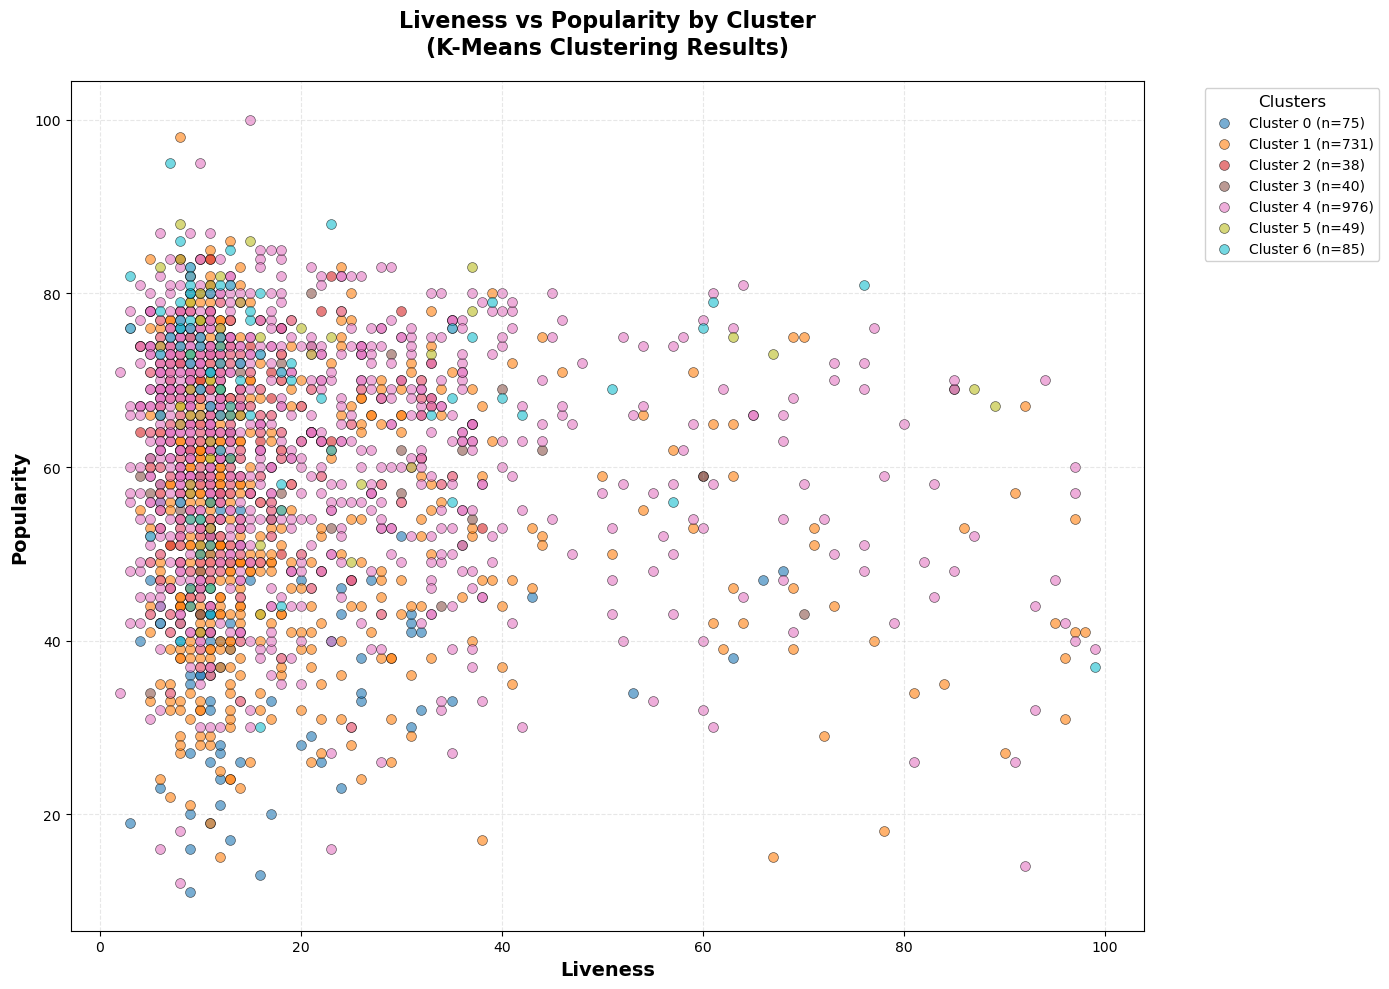

SUMMARY STATISTICS: Liveness vs Popularity by Cluster
Cluster    Count      Avg Liveness    Avg Popularity  Liveness Range       Popularity Range    
0          75         18.20           37.27           3.0-68.0             11-63               
1          731        17.37           56.60           4.0-98.0             15-98               
2          38         16.37           67.66           4.0-38.0             47-84               
3          40         22.55           60.20           4.0-85.0             34-80               
4          976        20.36           61.87           2.0-99.0             12-100              
5          49         19.20           68.59           6.0-89.0             41-88               
6          85         17.73           68.27           3.0-99.0             30-95               
CORRELATION ANALYSIS: Liveness vs Popularity
(Correlation coefficient: -1 to +1, where +1 = strong positive, -1 = strong negative, 0 = no correlation)
Cluster 0: Weak or no corre

In [45]:

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

print("VISUALIZATION: Liveness vs Popularity by Cluster")
print(f"\nUsing dataset: df_with_clusters (from Part 1E)")
print(f"Total songs: {len(df_with_clusters)}")
print(f"Number of clusters: {df_with_clusters['Cluster'].nunique()}\n")

plt.style.use('default')
sns.set_palette("husl")  # Use a color palette that provides good distinction between clusters

fig, ax = plt.subplots(figsize=(14, 10))

cluster_ids = sorted(df_with_clusters['Cluster'].unique())
num_clusters = len(cluster_ids)

colors = plt.cm.tab10(np.linspace(0, 1, num_clusters))

for i, cluster_id in enumerate(cluster_ids):
    cluster_data = df_with_clusters[df_with_clusters['Cluster'] == cluster_id]
    
    liveness = cluster_data['Liveness']
    popularity = cluster_data['Popularity']
    
    ax.scatter(liveness, popularity, 
               c=[colors[i]], 
               label=f'Cluster {cluster_id} (n={len(cluster_data)})',
               alpha=0.6, 
               s=50,
               edgecolors='black',
               linewidths=0.5)

ax.set_xlabel('Liveness', fontsize=14, fontweight='bold')
ax.set_ylabel('Popularity', fontsize=14, fontweight='bold')
ax.set_title('Liveness vs Popularity by Cluster\n(K-Means Clustering Results)', 
             fontsize=16, fontweight='bold', pad=20)

ax.grid(True, alpha=0.3, linestyle='--')

ax.legend(title='Clusters', 
          bbox_to_anchor=(1.05, 1), 
          loc='upper left',
          fontsize=10,
          title_fontsize=12,
          framealpha=0.9)

plt.tight_layout()

plt.show()

print("SUMMARY STATISTICS: Liveness vs Popularity by Cluster")
print(f"{'Cluster':<10} {'Count':<10} {'Avg Liveness':<15} {'Avg Popularity':<15} {'Liveness Range':<20} {'Popularity Range':<20}")

for cluster_id in cluster_ids:
    cluster_data = df_with_clusters[df_with_clusters['Cluster'] == cluster_id]
    avg_liveness = cluster_data['Liveness'].mean()
    avg_popularity = cluster_data['Popularity'].mean()
    liveness_range = f"{cluster_data['Liveness'].min():.1f}-{cluster_data['Liveness'].max():.1f}"
    popularity_range = f"{cluster_data['Popularity'].min():.0f}-{cluster_data['Popularity'].max():.0f}"
    
    print(f"{cluster_id:<10} {len(cluster_data):<10} {avg_liveness:<15.2f} {avg_popularity:<15.2f} {liveness_range:<20} {popularity_range:<20}")


print("CORRELATION ANALYSIS: Liveness vs Popularity")
print("(Correlation coefficient: -1 to +1, where +1 = strong positive, -1 = strong negative, 0 = no correlation)")

for cluster_id in cluster_ids:
    cluster_data = df_with_clusters[df_with_clusters['Cluster'] == cluster_id]
    correlation = cluster_data['Liveness'].corr(cluster_data['Popularity'])
    
    if abs(correlation) > 0.3:
        strength = "Strong" if abs(correlation) > 0.7 else "Moderate"
        direction = "positive" if correlation > 0 else "negative"
        print(f"Cluster {cluster_id}: {strength} {direction} correlation (r = {correlation:.3f})")
    else:
        print(f"Cluster {cluster_id}: Weak or no correlation (r = {correlation:.3f})")

overall_correlation = df_with_clusters['Liveness'].corr(df_with_clusters['Popularity'])
print(f"\nOverall Dataset: Correlation = {overall_correlation:.3f}")

print("\nVisualization complete! Each point is colored according to its cluster assignment.")



### Interpretation of Liveness vs Popularity Visualization (Part 1H):

#### **Actual Statistics from Output:**

**Average Liveness & Popularity by Cluster:**
- **Cluster 0**: Liveness 18.20, Popularity 37.27 (lowest popularity)
- **Cluster 1**: Liveness 17.37, Popularity 56.60
- **Cluster 2**: Liveness 16.37, Popularity 67.66 (highest popularity, low liveness)
- **Cluster 3**: Liveness 22.55 (highest), Popularity 60.20
- **Cluster 4**: Liveness 20.36, Popularity 61.87
- **Cluster 5**: Liveness 19.20, Popularity 68.59 (highest popularity)
- **Cluster 6**: Liveness 17.73, Popularity 68.27 (high popularity)

**Correlation Analysis:**
- **Overall Dataset**: r = -0.112 (weak negative correlation)
- **All clusters**: Weak or no correlation (r ranges from -0.175 to 0.121)
- **Cluster 1**: r = -0.175 (weakest negative - studio music more popular)
- **Cluster 0**: r = 0.121 (only positive, but weak)

#### **Key Observations:**

1. **Popularity Distribution**: Clusters 2, 5, and 6 have highest popularity (67-69), while Cluster 0 has lowest (37.27) - aligns with niche Dutch indie genre.

2. **Liveness Range**: Cluster 3 has highest average liveness (22.55), suggesting more live/concert-style recordings. Most clusters have similar liveness (16-20), indicating predominantly studio recordings.

3. **No Strong Correlation**: All correlations are weak (|r| < 0.3), meaning Liveness and Popularity are largely independent - popularity is driven by factors other than liveness.

4. **Cluster Overlap**: Clusters overlap in this 2D space because clustering uses 159 features, not just these two. The overlap is expected and validates that clusters differ in other dimensions (Energy, Danceability, Genre, etc.).

5. **Pattern**: High popularity clusters (2, 5, 6) tend to have lower liveness, suggesting mainstream hits are typically studio-produced rather than live recordings.


## Task2: Hierarchical Clustering (35 points)

Simply run the cell to read the data and plot it.

In [46]:
df = pd.read_csv('spotify (1).csv')
df.head()

,Index,Title,Artist,Top Genre,Year,Beats Per Minute (BPM),Energy,Danceability,Loudness (dB),Liveness,Valence,Length (Duration),Acousticness,Speechiness,Popularity
0,1,Sunrise,Norah Jones,adult standards,2004,157,30,53,-14,11,68,201,94,3,71
1,2,Black Night,Deep Purple,album rock,2000,135,79,50,-11,17,81,207,17,7,39
2,3,Clint Eastwood,Gorillaz,alternative hip hop,2001,168,69,66,-9,7,52,341,2,17,69
3,4,The Pretender,Foo Fighters,alternative metal,2007,173,96,43,-4,3,37,269,0,4,76
4,5,Waitin' On A Sunny Day,Bruce Springsteen,classic rock,2002,106,82,58,-5,10,87,256,1,3,59


### Part 2A: 10 points

Plot the co-ordinates from the imported data and guess possible clusters that could be formed.

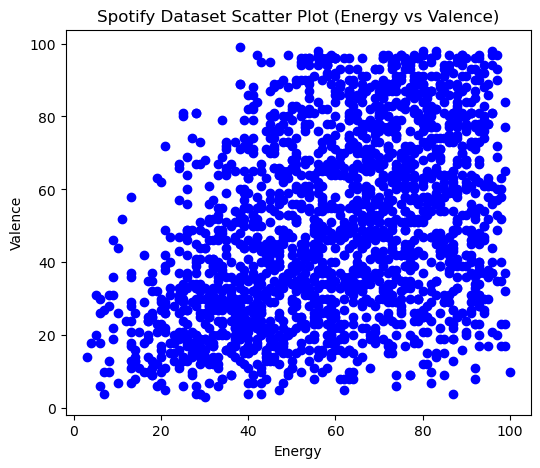

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))
plt.scatter(df['Energy'], df['Valence'], c='blue')
plt.xlabel('Energy')
plt.ylabel('Valence')
plt.title('Spotify Dataset Scatter Plot (Energy vs Valence)')
plt.show()


Guess the possible clusters

Based on the scatter plot of Energy vs Valence, the points naturally fall into around 2–3 groups.
One group is concentrated in the lower-left area (low energy, low valence).
Another group forms in the middle/upper-middle region.
A third smaller group appears more toward the upper-right.

So the data roughly forms 2–3 clusters before applying hierarchical clustering.

### Part 2B: 15 points

Using Hierarchical clustering with euclidean + ward and manhattan + average, display the results for clusters 4,5,6 and 7. Add tittle for each plot.

From the results, what according to you should be the appropriate value of K and for which pair of affinity and linkage? Interpret your results. Did this match with your previous guess?

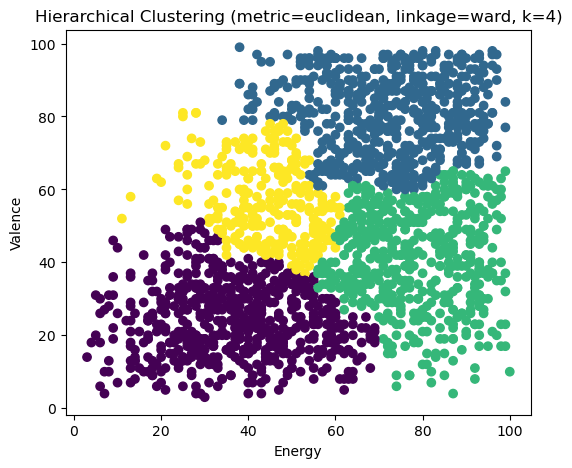

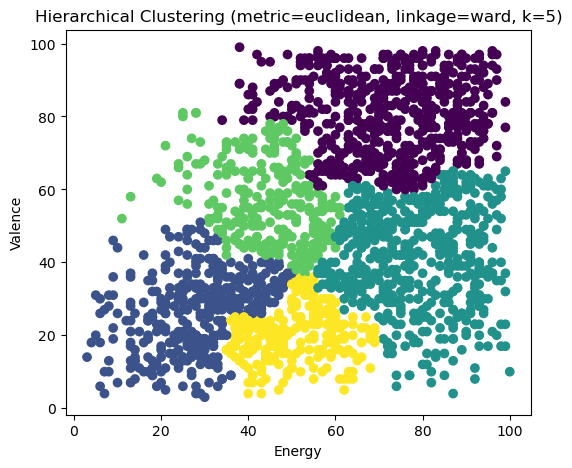

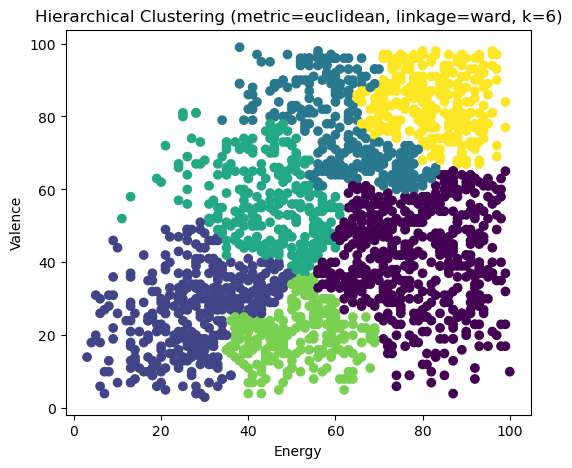

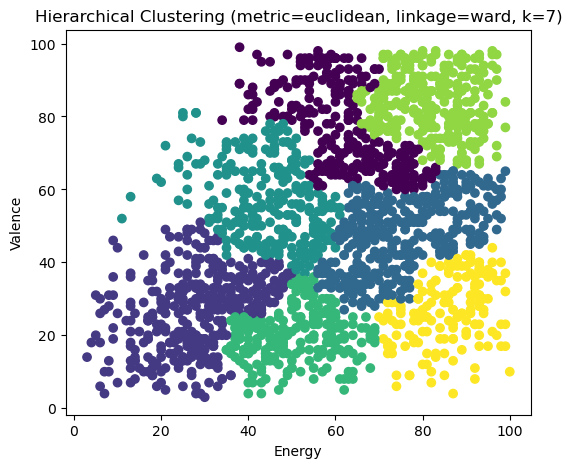

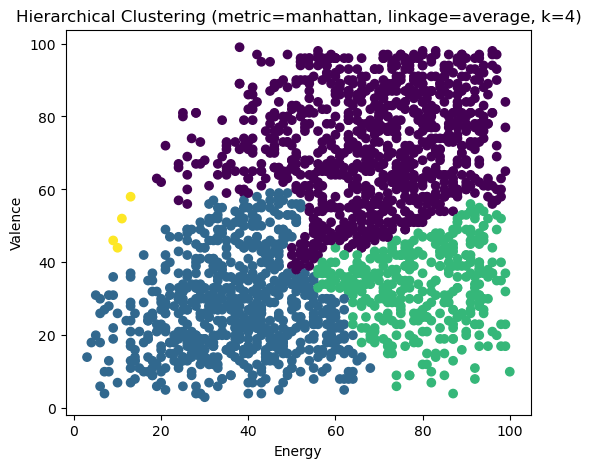

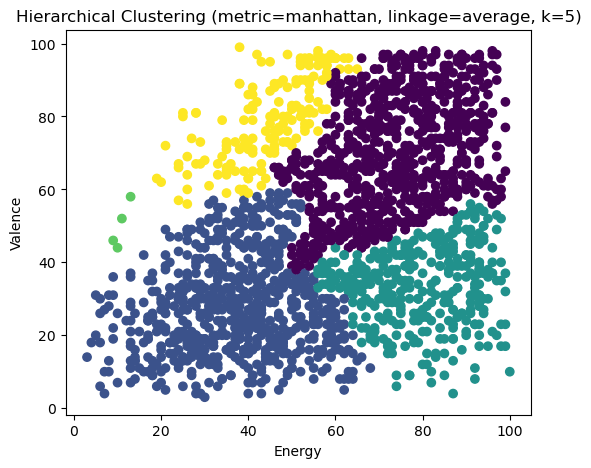

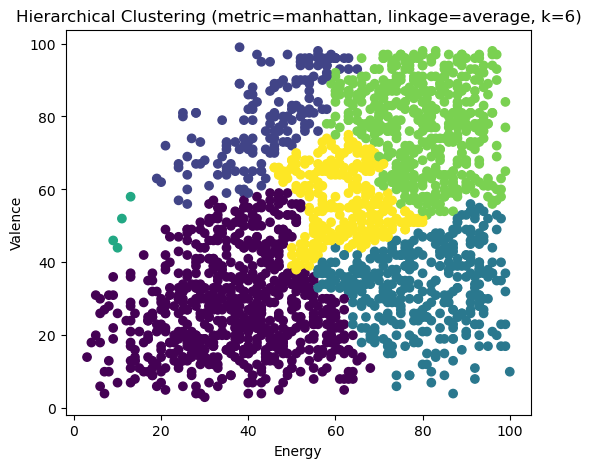

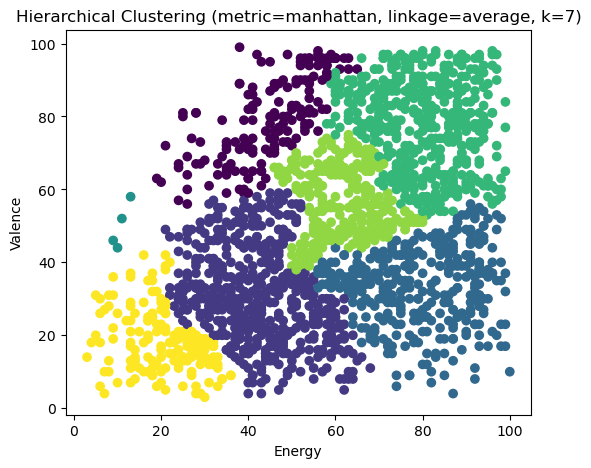

In [48]:
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt

X = df[['Energy', 'Valence']].values

configs = [
    ('euclidean', 'ward'),
    ('manhattan', 'average')
]

ks = [4, 5, 6, 7]

for metric, linkage in configs:
    for k in ks:
        
        if linkage == 'ward' and metric != 'euclidean':
            continue

        model = AgglomerativeClustering(
            n_clusters=k,
            metric=metric,
            linkage=linkage
        )

        labels = model.fit_predict(X)

        plt.figure(figsize=(6,5))
        plt.scatter(X[:, 0], X[:, 1], c=labels)
        plt.xlabel('Energy')
        plt.ylabel('Valence')
        plt.title(f'Hierarchical Clustering (metric={metric}, linkage={linkage}, k={k})')
        plt.show()

Interpretation

After looking at all the cluster plots, the combination that gives the most clear and separated groups is Euclidean distance with Ward linkage.
With this setup, k = 4 fits the data well. The clusters are distinct, and it doesn’t feel like the data is being forced into too many small groups.

When k is increased to 5, 6, or 7, the clusters start getting split in ways that don’t add any real meaning — it’s basically just dividing existing groups for no reason.

For the Manhattan + Average option, the clusters aren’t as compact, and the boundaries look more mixed, so that combination doesn’t work as well here.

So the best choice is k = 4 using Euclidean + Ward.

Match with the earlier guess:
From the first scatter plot (Energy vs Valence), the data looked like it had about 2–3 main groups.
Hierarchical clustering gives 4, which still makes sense because one of the larger groups is being divided into two smaller, valid subgroups.
So overall, the result lines up well with the earlier guess.

### Part 2C: 10 points

For your Selection of K, display the dendogram for the analysis and plot line where K clusters are formed. Give proper Title.

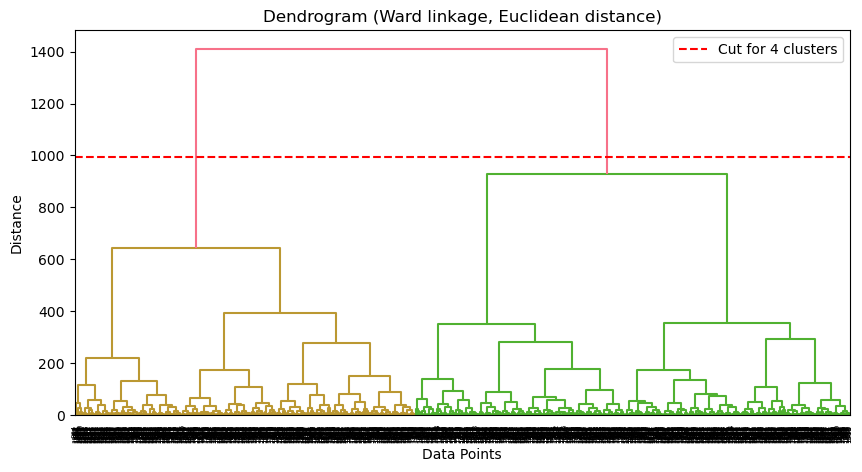

In [49]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

X = df[['Energy', 'Valence']].values  # Updated features

Z = linkage(X, method='ward', metric='euclidean')

plt.figure(figsize=(10, 5))
dendrogram(Z)
plt.title('Dendrogram (Ward linkage, Euclidean distance)')
plt.xlabel('Data Points')
plt.ylabel('Distance')

K = 4
last = Z[-(K-1):, 2]   # last (K-1) merge distances
threshold = last.mean()
plt.axhline(y=threshold, color='red', linestyle='--', label='Cut for 4 clusters')
plt.legend()
plt.show()

Dendrogram Interpretation

The dendrogram shows a clear jump in merge distance near the level that splits the dataset into 4 main branches.
Cutting the tree at this height (red line) separates the Energy–Valence space into 4 well-formed groups.

Below this cut point, merges occur at small distances, meaning those points are very similar.

Above this point, merge distances increase sharply, showing that combining clusters further would mix very different groups.

This validates that 4 clusters is a natural choice for the dataset and supports the selection made in Part 2B.

## Task 3: AI (15 Points)

Perform all the task using any AI where the data and the questions are same as that for Task 1.

Provide the screenshots of prompts and output of AI in word document.

## Task 4: Critical Thinking (15 Points)

### Part 1:
Why is the elbow method used to determine the optimal number of clusters in k-means clustering? What are its limitations?


The elbow method determines optimal k by plotting SSE (Sum of Squared Errors) against k values. The "elbow" point indicates where adding more clusters provides diminishing returns. It's intuitive, computationally efficient, and doesn't require prior knowledge of cluster count.

#### **Limitations:**

1. **Subjective**: The elbow may not be clearly defined, leading to inconsistent interpretations.
2. **Focuses on Compactness Only**: Measures within-cluster variance but ignores between-cluster separation.
3. **Dataset Sensitivity**: May fail for non-spherical clusters, varying sizes, or high-dimensional data.
4. **No Statistical Validation**: Doesn't provide significance tests or confidence intervals.
5. **Ambiguous Results**: Smooth curves without distinct elbows make optimal k identification difficult.

**Best Practice**: Use as a starting point and validate with other methods (e.g., Silhouette Score) for robust cluster selection.


### Part 2:
Why is it useful to visualize a dendrogram when performing hierarchical clustering? How can you interpret it?


It shows how the data points are grouped step by step, starting from individual points and moving up to bigger clusters.
It helps in choosing the number of clusters because you can clearly see where there are big jumps in distance.
The height where two branches merge tells how different those clusters are.
Outliers or points that don’t fit well usually merge at a much higher distance, so they’re easy to spot.
Overall, it gives a clear picture of how the data is structured, which is something flat clustering doesn’t show.

How to interpret a dendrogram

The bottom part (leaves) represents each individual data point.
The vertical height where branches join shows how far apart those points or clusters were.
If you draw a horizontal line at a certain height, the number of vertical lines it cuts equals the number of clusters.
Big vertical gaps between merges usually indicate a natural place to cut the dendrogram.
Small merge heights mean the points are very similar, while taller merges show bigger differences.

Limitations / notes

With large datasets, the dendrogram can get too crowded and hard to read.
The result depends on the distance metric and linkage method you choose.
It’s mainly a visual tool, so it’s good to use it along with other measures (like silhouette score) when deciding K.